In [1]:
!pip install fastai --upgrade
!pip install utils

     |████████████████████████████████| 358kB 4.4MB/s 
     |████████████████████████████████| 40kB 4.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
from fastai.vision.all import *
from utils import *
import os
import cv2

In [3]:
path = Path('../dataset')

In [4]:
path.ls()

(#4) [Path('../dataset/.DS_Store'),Path('../dataset/WIDER FACE'),Path('../dataset/gender_dataset'),Path('../dataset/age_dataset')]

In [5]:
(path/'gender_dataset').ls()

(#23708) [Path('../dataset/gender_dataset/9_1_2_20161219204347420.jpg.chip.jpg'),Path('../dataset/gender_dataset/36_0_1_20170117163203851.jpg.chip.jpg'),Path('../dataset/gender_dataset/86_1_0_20170120225751953.jpg.chip.jpg'),Path('../dataset/gender_dataset/26_1_0_20170116171048641.jpg.chip.jpg'),Path('../dataset/gender_dataset/1_1_2_20161219154612988.jpg.chip.jpg'),Path('../dataset/gender_dataset/52_0_1_20170117161018159.jpg.chip.jpg'),Path('../dataset/gender_dataset/25_1_0_20170117134403373.jpg.chip.jpg'),Path('../dataset/gender_dataset/16_0_0_20170104003740977.jpg.chip.jpg'),Path('../dataset/gender_dataset/27_0_3_20170119210058457.jpg.chip.jpg'),Path('../dataset/gender_dataset/36_0_3_20170119180245724.jpg.chip.jpg')...]

In [6]:
fname = (path/'gender_dataset').ls()[0]
fname

Path('../dataset/gender_dataset/9_1_2_20161219204347420.jpg.chip.jpg')

In [7]:
re.findall(r'^\d+_(\d)_.+.jpg', '115_0_2_20170112213257263.jpg.chip.jpg')

['0']

In [5]:
gender = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items = get_image_files,
                   splitter = RandomSplitter(valid_pct=0.2, seed = 42),
                   get_y = using_attr(RegexLabeller(r'^\d+_(\d)_.+.jpg'), 'name'),
                   item_tfms = Resize(640),
                   batch_tfms = aug_transforms(size = 640, min_scale = 0.75))

In [ ]:
gender.summary(path/'gender_dataset')

In [6]:
dls = gender.dataloaders(path/'gender_dataset')

In [ ]:
b = dls.one_batch()
b[0].shape

torch.Size([64, 1, 480, 480])

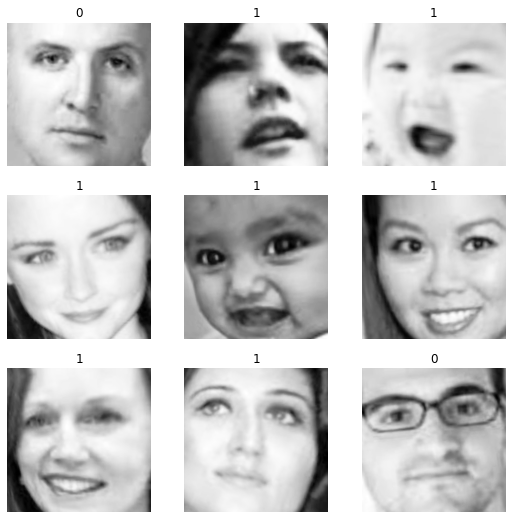

In [7]:
dls.show_batch(cmap='Greys_r')

# First attempt

First attempt made on color datablock

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.510329,0.280400,0.112002,1:34:08


epoch,train_loss,valid_loss,error_rate,time
0,0.288533,0.218154,0.090698,02:32


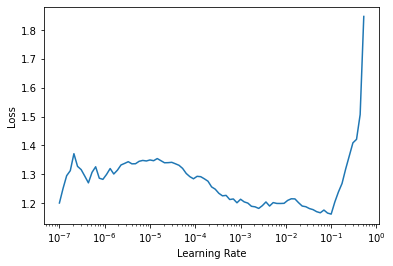

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-07


In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,0.608358,0.419705,0.182240,02:41
1,0.414114,0.345748,0.151867,02:42


epoch,train_loss,valid_loss,error_rate,time
0,0.271139,0.259093,0.101455,02:53
1,0.249746,0.200728,0.080785,02:51
2,0.198332,0.173910,0.072137,02:52
3,0.150033,0.150928,0.055684,02:52
4,0.130185,0.146768,0.051044,02:53


In [ ]:
learn.export(fname='gender.pkl')

# Second Attempt

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


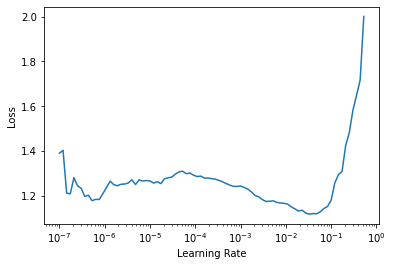

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [13]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 3.31e-03, steepest point: 3.98e-06


epoch,train_loss,valid_loss,accuracy,time
0,0.462337,0.363276,0.842649,1:40:28
1,0.328166,0.282644,0.880827,10:07
2,0.283425,0.248091,0.894115,10:10


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.981071586167673e-06)

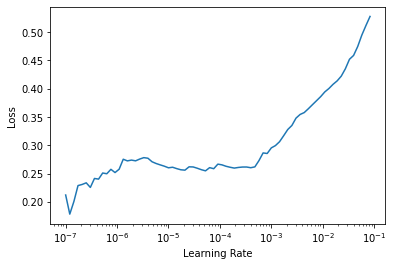

In [14]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.468592,0.357511,0.840540,10:08
1,0.332041,0.281504,0.875554,10:09
2,0.283564,0.256556,0.892006,10:10


epoch,train_loss,valid_loss,accuracy,time
0,0.268307,0.242710,0.902974,14:01
1,0.252426,0.247738,0.893904,14:01
2,0.233001,0.208402,0.910146,14:01
3,0.220952,0.194379,0.923223,14:01
4,0.200784,0.190804,0.924910,14:01
5,0.179090,0.183804,0.931449,14:01
6,0.166350,0.183081,0.931449,14:01
7,0.141908,0.170006,0.937566,14:01
8,0.118649,0.177235,0.937988,14:01
9,0.101486,0.189007,0.936722,14:01


In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export(fname='gender1.pkl')

# Third Attempt


In [8]:
gender = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   splitter = RandomSplitter(valid_pct=0.2, seed = 42),
                   get_y = using_attr(RegexLabeller(r'^\d+_(\d)_.+.jpg'), 'name'),
                   item_tfms = Resize(640),
                   batch_tfms = aug_transforms(size = 640, min_scale = 0.75))

In [9]:
dls = gender.dataloaders(path/'gender_dataset')

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
lr_min,lr_steep = learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 7e-3)
learn.unfreeze()
learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 7e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

In [ ]:
learn.export(fname='gender2.pkl')

# Fourth Attempt
## Modifying input layer of resnet